# Segmentación y detección de anomalías en pacientes crónicos

* Autor:Robinson Niño

### Paso 0: Hago un analisis rapido en busca de nulos

In [1]:
import pandas as pd

# Cargar el dataset
df = pd.read_csv('diabetes.csv')

# Vista rapida
display(df.head())

# 1. Analisis rápido de nulos
print("\nConteo de valores nulos por columna:")
print(df.isnull().sum())

# 2. Separacion en features y target
# Asumimos que la columna 'Outcome' es el target
X = df.drop(columns=['Outcome'])
y = df['Outcome']

print("DImension de X:", X.shape)
print("DImension de y:", y.shape)

#Aplico info() para ver el tipo de datos por columna
df.info()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



Conteo de valores nulos por columna:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
DImension de X: (768, 8)
DImension de y: (768,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       7

### PASO 1: Aplico preprocesamiento de datos

#### Aplico escalamiento de datos

Por qué escalar. DBSCAN/HDBSCAN y proyecciones (PCA/t-SNE/UMAP) se basan en distancias; si no escalas, variables con mayor rango (p. ej., Glucose o Insulin) dominarán la geometría y sesgarán los clústeres.

In [2]:
from sklearn.preprocessing import StandardScaler

# Inicializar el escalador
scaler = StandardScaler()

# Ajustar y transformar X
X_scaled = scaler.fit_transform(X)




Caracteristicas de cada metodo:

**PCA**: lineal, conserva varianza global, ayuda a interpretar carga de componentes (qué variables “explican” la dispersión).

**t-SNE**: no lineal, preserva estructura local; ideal para ver “islas” de pacientes, pero no es para distancias globales.

**UMAP**: no lineal, más rápido que t-SNE, preserva estructura local y parte de la global; suele separar mejor subgrupos.

#### Aplico reduccion de dimensionalidad con PCA

* Reduzco a 5 componentes.
* La varianza total al reducir a 5 componentes es de un 0.811.

In [3]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Reducir a 5 componentes con PCA
pca_5 = PCA(n_components=5, random_state=42)
X_pca5 = pca_5.fit_transform(X_scaled)

print("Varianza total explicada por 5 componentes:", pca_5.explained_variance_ratio_.sum())




Varianza total explicada por 5 componentes: 0.8116366730564857


#### Aplico reduccion con t-sne

* COn t-sne reduzco ahora la dimensionalidad a 2 componentes.

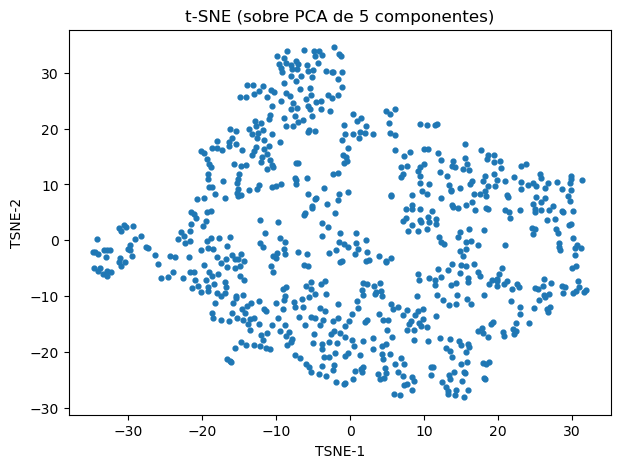

In [4]:
# 2. Reducir a 2D con t-SNE sobre PCA reducido
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_pca5)

# 3. Visualizar
plt.figure(figsize=(7,5))
plt.scatter(X_tsne[:,0], X_tsne[:,1], s=12)
plt.title("t-SNE (sobre PCA de 5 componentes)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.show()

#### Aplico reduccion de datos con UMAP

/home/apolo/anaconda3/envs/scikit-learn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/apolo/anaconda3/envs/scikit-learn/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


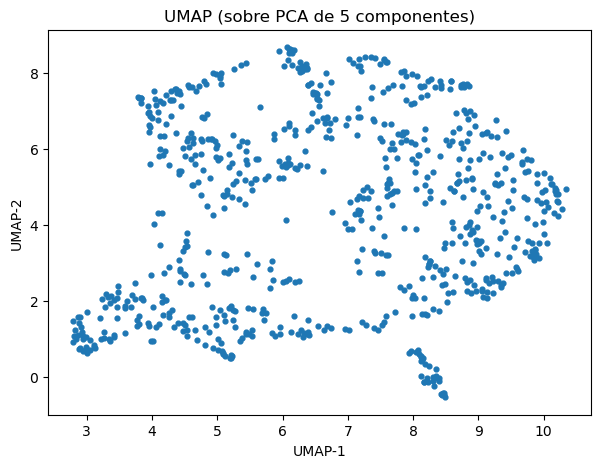

In [5]:
import umap.umap_ as umap

# Reducir a 2D con UMAP sobre PCA reducido
umap_2d = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_2d.fit_transform(X_pca5)

# Visualizar
plt.figure(figsize=(7,5))
plt.scatter(X_umap[:,0], X_umap[:,1], s=12)
plt.title("UMAP (sobre PCA de 5 componentes)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()


### Paso 2: APlico DBSCAN y HDBSCAN a los datos tratados con tsne

[DBSCAN] clusters (sin ruido): 15
[DBSCAN] ruido (-1): 738 puntos


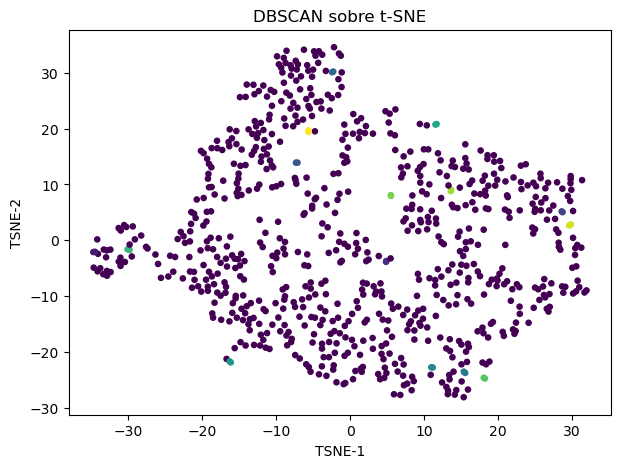

[HDBSCAN] clusters (sin ruido): 21
[HDBSCAN] ruido (-1): 390 puntos


/home/apolo/anaconda3/envs/scikit-learn/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/apolo/anaconda3/envs/scikit-learn/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


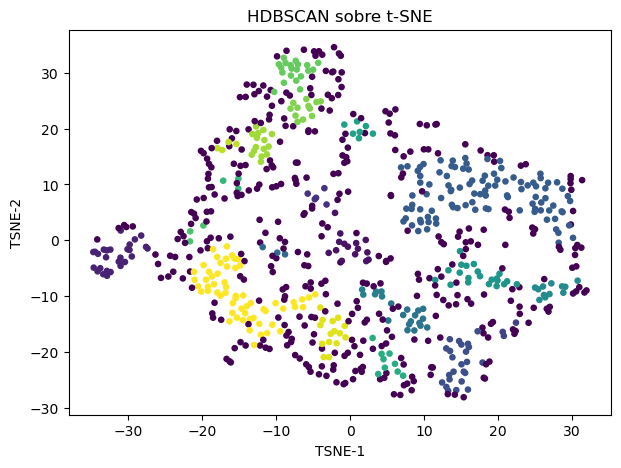

In [6]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# --- DBSCAN ---
dbscan = DBSCAN(eps=0.3, min_samples=2)  # ajusta eps y min_samples si es necesario
db_labels_tsne = dbscan.fit_predict(X_tsne)

print(f"[DBSCAN] clusters (sin ruido): {len(set(db_labels_tsne) - {-1})}")
print(f"[DBSCAN] ruido (-1): {list(db_labels_tsne).count(-1)} puntos")

plt.figure(figsize=(7,5))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=db_labels_tsne, s=14)
plt.title("DBSCAN sobre t-SNE")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.show()

# --- HDBSCAN ---
import hdbscan
hdb = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=10)
hdb_labels_tsne = hdb.fit_predict(X_tsne)
print(f"[HDBSCAN] clusters (sin ruido): {len(set(hdb_labels_tsne) - {-1})}")
print(f"[HDBSCAN] ruido (-1): {list(hdb_labels_tsne).count(-1)} puntos")
plt.figure(figsize=(7,5))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=hdb_labels_tsne, s=14)
plt.title("HDBSCAN sobre t-SNE")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.show()


#### Aplico DBSCAN y HDBSCAN a los datos tratados con UMAP

[DBSCAN-UMAP] clusters (sin ruido): 20
[DBSCAN-UMAP] ruido (-1): 9 puntos


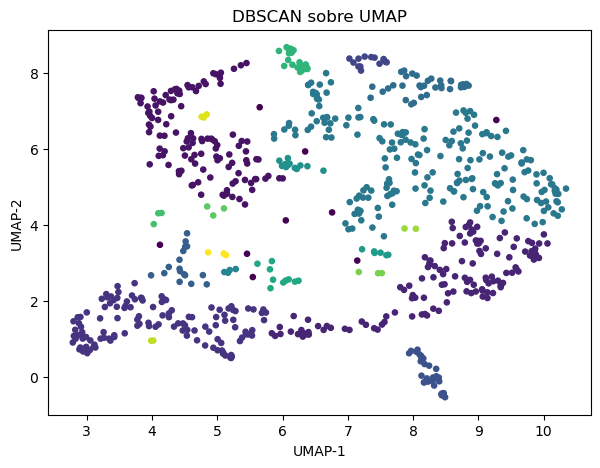

[HDBSCAN-UMAP] clusters (sin ruido): 2
[HDBSCAN-UMAP] ruido (-1): 6 puntos


/home/apolo/anaconda3/envs/scikit-learn/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/apolo/anaconda3/envs/scikit-learn/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


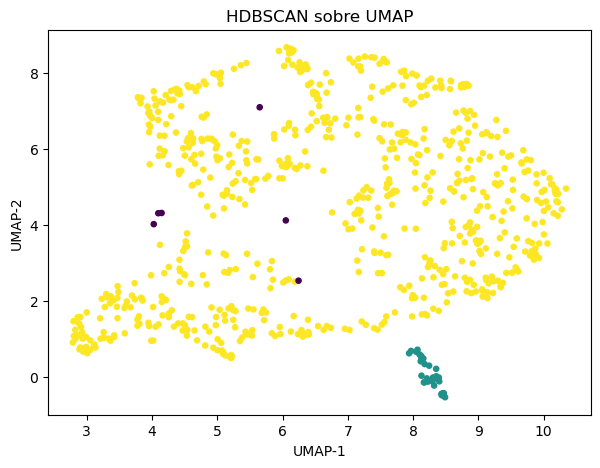

In [7]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# --- DBSCAN ---
dbscan_umap = DBSCAN(eps=0.3, min_samples=2)  # ajusta eps/min_samples según sea necesario
db_labels_umap = dbscan_umap.fit_predict(X_umap)

print(f"[DBSCAN-UMAP] clusters (sin ruido): {len(set(db_labels_umap) - {-1})}")
print(f"[DBSCAN-UMAP] ruido (-1): {list(db_labels_umap).count(-1)} puntos")

plt.figure(figsize=(7,5))
plt.scatter(X_umap[:,0], X_umap[:,1], c=db_labels_umap, s=14)
plt.title("DBSCAN sobre UMAP")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

# --- HDBSCAN ---
import hdbscan
hdb_umap = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=10)
hdb_labels_umap = hdb_umap.fit_predict(X_umap)
print(f"[HDBSCAN-UMAP] clusters (sin ruido): {len(set(hdb_labels_umap) - {-1})}")
print(f"[HDBSCAN-UMAP] ruido (-1): {list(hdb_labels_umap).count(-1)} puntos")
plt.figure(figsize=(7,5))
plt.scatter(X_umap[:,0], X_umap[:,1], c=hdb_labels_umap, s=14)
plt.title("HDBSCAN sobre UMAP")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()


### Evaluo la calidad de los clusteres

In [8]:
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score

def calcular_metricas(emb, labels):
    mask = labels != -1
    clusters = set(labels[mask])
    if len(clusters) >= 2:
        sil = silhouette_score(emb[mask], labels[mask])
        dbi = davies_bouldin_score(emb[mask], labels[mask])
        return sil, dbi
    else:
        return None, None

# Crear lista de resultados
resultados = []

# t-SNE
sil, dbi = calcular_metricas(X_tsne, db_labels_tsne)
resultados.append(["t-SNE", "DBSCAN", sil, dbi])

try:
    sil, dbi = calcular_metricas(X_tsne, hdb_labels_tsne)
    resultados.append(["t-SNE", "HDBSCAN", sil, dbi])
except NameError:
    pass

# UMAP
sil, dbi = calcular_metricas(X_umap, db_labels_umap)
resultados.append(["UMAP", "DBSCAN", sil, dbi])

try:
    sil, dbi = calcular_metricas(X_umap, hdb_labels_umap)
    resultados.append(["UMAP", "HDBSCAN", sil, dbi])
except NameError:
    pass

# Convertir a DataFrame
df_metricas = pd.DataFrame(resultados, columns=["Espacio", "Algoritmo", "Silueta", "Davies-Bouldin"])
display(df_metricas)


,Espacio,Algoritmo,Silueta,Davies-Bouldin
0,t-SNE,DBSCAN,0.953511,0.047581
1,t-SNE,HDBSCAN,0.430414,0.542567
2,UMAP,DBSCAN,-0.047020,1.075708
3,UMAP,HDBSCAN,0.213440,0.702932


### Busqueda de anomalias usando Isolation Forest y OneClassSVM

Isolation Forest: 102 anómalos (13.28%)
One-Class SVM: 47 anómalos (6.12%)


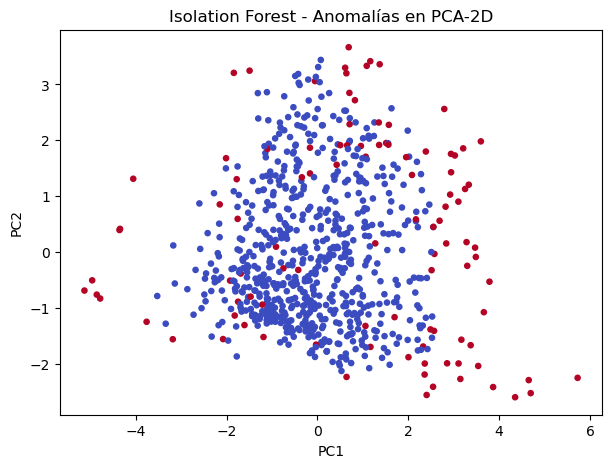

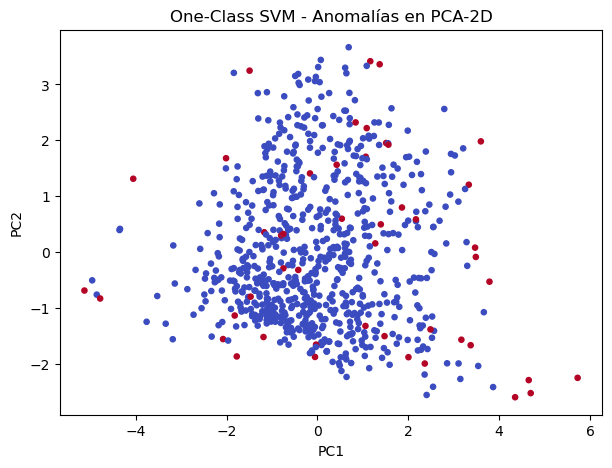

In [9]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import numpy as np

# --- Isolation Forest ---
iso = IsolationForest(n_estimators=300, contamination='auto', random_state=42)
iso_pred = iso.fit_predict(X_scaled)  # -1 = anómalo, 1 = normal
iso_anom_idx = np.where(iso_pred == -1)[0]

print(f"Isolation Forest: {len(iso_anom_idx)} anómalos ({len(iso_anom_idx)/len(X_scaled)*100:.2f}%)")

# --- One-Class SVM ---
oc = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)  # nu ~ proporción de anómalos esperada
oc_pred = oc.fit_predict(X_scaled)  # -1 = anómalo, 1 = normal
oc_anom_idx = np.where(oc_pred == -1)[0]

print(f"One-Class SVM: {len(oc_anom_idx)} anómalos ({len(oc_anom_idx)/len(X_scaled)*100:.2f}%)")

# --- Visualización en PCA-2D ---
from sklearn.decomposition import PCA
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=(iso_pred==-1).astype(int), cmap="coolwarm", s=14)
plt.title("Isolation Forest - Anomalías en PCA-2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=(oc_pred==-1).astype(int), cmap="coolwarm", s=14)
plt.title("One-Class SVM - Anomalías en PCA-2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [10]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import pandas as pd
import numpy as np

# --- Isolation Forest ---
iso = IsolationForest(n_estimators=300, contamination='auto', random_state=42)
iso_pred = iso.fit_predict(X_scaled)  # -1 = anómalo, 1 = normal
iso_anom = (iso_pred == -1).astype(int)  # 1 = anómalo

# --- One-Class SVM ---
oc = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
oc_pred = oc.fit_predict(X_scaled)  # -1 = anómalo, 1 = normal
oc_anom = (oc_pred == -1).astype(int)  # 1 = anómalo

# --- Crear DataFrame con resultados ---
anom_df = pd.DataFrame({
    "Paciente_ID": np.arange(len(X_scaled)),
    "IsolationForest_Anomalo": iso_anom,
    "OneClassSVM_Anomalo": oc_anom
})

display(anom_df)

# Pacientes que son anómalos en al menos una técnica
anom_ambos = anom_df[(anom_df["IsolationForest_Anomalo"] == 1) | (anom_df["OneClassSVM_Anomalo"] == 1)]
print(f"Total pacientes anómalos en al menos una técnica: {anom_ambos.shape[0]}")
display(anom_ambos)


,Paciente_ID,IsolationForest_Anomalo,OneClassSVM_Anomalo
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,1,0
...,...,...,...
763,763,1,1
764,764,0,0
765,765,0,0
766,766,0,0


Total pacientes anómalos en al menos una técnica: 113


,Paciente_ID,IsolationForest_Anomalo,OneClassSVM_Anomalo
4,4,1,0
7,7,1,0
8,8,1,0
9,9,1,0
12,12,1,0
...,...,...,...
728,728,0,1
744,744,1,0
753,753,1,0
759,759,1,0


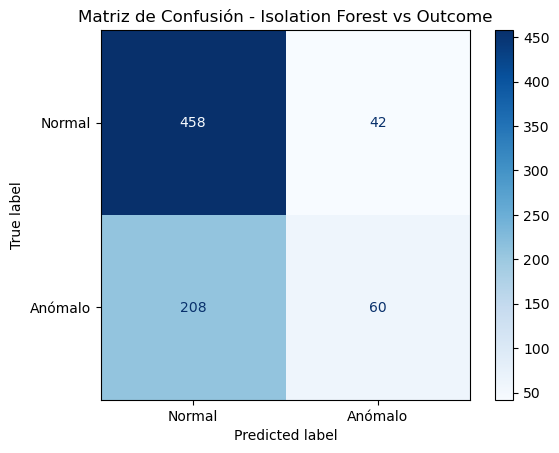

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Suponiendo que 'y' es la columna Outcome original
# y que iso_anom = 1 si el modelo lo marcó como anómalo, 0 si no
cm = confusion_matrix(y, iso_anom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anómalo"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión - Isolation Forest vs Outcome")
plt.show()


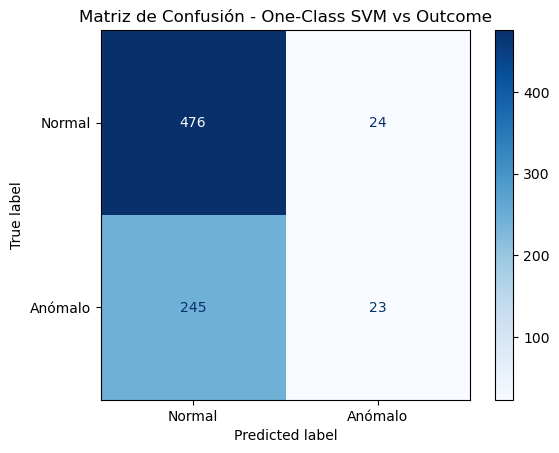

Matriz de confusión (valores):
 [[476  24]
 [245  23]]


In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Matriz de confusión para One-Class SVM vs Outcome real
cm_oc = confusion_matrix(y, oc_anom)
disp_oc = ConfusionMatrixDisplay(confusion_matrix=cm_oc,
                                 display_labels=["Normal", "Anómalo"])
disp_oc.plot(cmap="Blues")
plt.title("Matriz de Confusión - One-Class SVM vs Outcome")
plt.show()

print("Matriz de confusión (valores):\n", cm_oc)


### Analisis

* Al usar  t-SNE + DBSCAN tengo un indice de silueta de 0.95 y Davies–Bouldin de 0.047. Esto me indica que los  clústeres estan extremadamente bien definidos. Esto sugiere que, en el espacio t-SNE, DBSCAN encontró un patrón muy limpio (probablemente pocos clústeres, pero muy densos).

* Caso contrario con UMAP + DBSCAN, donde el valor de la silueta es negativa y Davies–Bouldin alto.